This notebook provides a procedure to compute the deformation of a bond. 

Comentaris. La referència de l'energia, estrictament parlant, hauria de ser l'energia dels fragments. Això no es té en compte. Es pot fixar la referència d'energia en la conformació més estable, igual que en els dihedres o els angles. 

In [ ]:
# general imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

from ase.visualize import view
from ase.io import trajectory
from ase import build

In [44]:
def evaluate_bond(molecule, bond_ids, mask,  calculator_list, search_space=None , resolution=None, save_dir='./'):
    '''
    Definition
    ----------
    Evaluates the PES of the breaking of a bond.
    bond_ids contain the index of the atoms that form the bond. 
    '''

    # set scan space and resolution. 
    if resolution is None:
        resolution = 40
    if search_space is None:
        search_space = [1.0, 6.0]
    dist_list = np.linspace(search_space[0], search_space[1], resolution)

    print(f'computing {molecule[bond_ids[0]].symbol}{molecule[bond_ids[0]].index}-{molecule[bond_ids[1]].symbol}{molecule[bond_ids[1]].index} PES\nscan range {search_space} Å')
    print(f'evaluating {len(dist_list)} distances')
    print(f'distances:\n{dist_list}\n')

    if len(calculator_list) == 1:
        traj_path = os.path.join(save_dir, 'bond_scan.traj')
        traj = trajectory.TrajectoryWriter(filename=traj_path, mode='w')

    # save energies
    energies = []

    # evaluate each calculator
    for calc_ in calculator_list: 

        calc_energy_list = []

        for d in dist_list:

            # define the configuration
            molecule.set_distance(bond_ids[0], bond_ids[1], d, mask=mask)
            molecule.calc = calc_
            potential_e = molecule.get_potential_energy()
            calc_energy_list.append(potential_e)
        
            if len(calculator_list) == 1:
                traj.write(molecule)

        # compute reference
        # TODO

        energies.append(calc_energy_list)

        if len(calculator_list) == 1:
            traj.close()

    return dist_list, energies



def plot_bond(distance_list, energy_list, calculator_names, calculator_colors, dist_name='', save_dir=None):
    '''
    Plot a bond scan. 
    '''

    if save_dir is None:
        save_dir = './'

    _color_list = ['black', 'red', 'orange', 'blue']
    _marker_list = ['^', 'd', 'v', 'o']

    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6,4)) 
    axes.tick_params(bottom=True, top=True, left=True, right=False, direction="in")
    axes.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")

    for k in range(len(calculator_names)):
        
        # gather the minimum energy structure
        idx = np.argmin(energy_list[k][:])
        min_energy = energy_list[k][idx]
        min_dih = distance_list[idx]

        # TODO convert energy from eV/particle to kcal/mol: 1 eV/molecule = 23.0605 kcal/mol

        axes.plot(distance_list, (np.array(energy_list[k][:])-min_energy), label=r'$\textnormal{' + calculator_names[k] + r'}$', color=calculator_colors[k], alpha=0.9)
        axes.scatter(min_dih, min_energy-min_energy, color=_color_list[k], marker=_marker_list[k], label=r'$\textnormal{reference energy at ' + f'{min_dih:.3f}' + r' Å}$')

    axes.set(xlabel=r'$\textnormal{' + f'{dist_name}' + r' bond distance}\;\textnormal{(deg)}$', ylabel=r'$\textnormal{potential energy}\;\textnormal{(eV)}$')
    axes.legend(loc='best')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{dist_name}'+'dihedral_PES.png'), dpi=300)
    plt.show(fig)

In [57]:
#=======================#
#       CALCULATOR      #
#=======================#

from mace.calculators import mace_mp, mace_off

macemp = mace_mp(
    model="medium", 
    dispersion=False, 
    default_dtype="float64", 
    device='cpu',
    )

maceoff = mace_off(
    model="medium", 
    device='cpu',
    default_dtype='float64'
    )

calculator_list = [macemp, maceoff]
calculator_names = ['MACE-MP', 'MACE-OFF']
calculator_colors = ['deeppink', 'darkgreen']

#calculator_list = [macemp]
#calculator_names = ['MACE-MP']

Using Materials Project MACE for MACECalculator with /Users/sergiortizropero/.cache/mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using MACE-OFF23 MODEL for MACECalculator with /Users/sergiortizropero/.cache/mace/MACE-OFF23_medium.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


0 C
1 C
2 O
3 H
4 H
5 H
6 H
7 H
8 H
computing C1-O2 PES
scan range [1.0, 7.0] Å
evaluating 40 distances
distances:
[1.         1.15384615 1.30769231 1.46153846 1.61538462 1.76923077
 1.92307692 2.07692308 2.23076923 2.38461538 2.53846154 2.69230769
 2.84615385 3.         3.15384615 3.30769231 3.46153846 3.61538462
 3.76923077 3.92307692 4.07692308 4.23076923 4.38461538 4.53846154
 4.69230769 4.84615385 5.         5.15384615 5.30769231 5.46153846
 5.61538462 5.76923077 5.92307692 6.07692308 6.23076923 6.38461538
 6.53846154 6.69230769 6.84615385 7.        ]



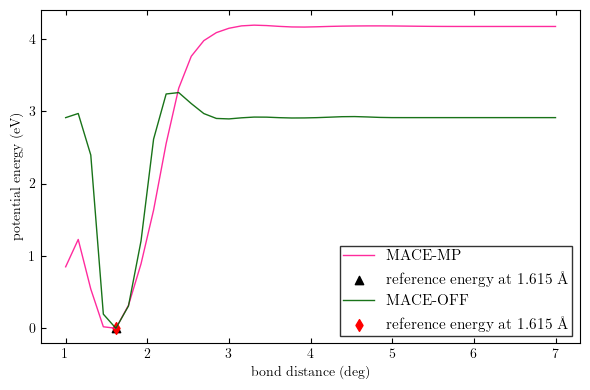

In [ ]:
#=======================#
#       PARAMETERS      #
#=======================#

# example: ETHANE
# ethane = build.molecule('C2H6')
# mask = [0, 1, 0, 0, 0, 1, 1, 1]
# bond_ids = [0, 1]




# define the molecule
ethanol = build.molecule('CH3CH2OH')

# select the C-C bond and provide the mask

for atom in ethanol:
    print(atom.index, atom.symbol)
#view(ethanol, viewer='ase')

bond_ids = [1, 2]
mask = [0, 0, 1, 1, 0, 0, 0, 0, 0]

# evaluate the conformations
distances, energies = evaluate_bond(ethanol, bond_ids, mask,  calculator_list, search_space=[1.0, 7.0])
plot_bond(distances, energies, calculator_names, calculator_colors, save_dir='./')

In [59]:
traj = trajectory.TrajectoryReader('./bond_scan.traj')
view(traj, viewer='ngl')